# Chapter 08: Dimension Reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA

## Principal component analysis (PCA)

The $k$-dimensional linear subspace $\mathcal{W}$ of $\mathbb{R}^d$ that minimizes $$ \sum_{i=1}^{m} \mathrm{dist}_{\ell_2}(x^{(i)},\mathcal{W})^2  $$ is spanned by the first $k$ left singular vectors of the data matrix $X\in\mathbb{R}^{d\times m}$, where the $i$-th column of the data matrix $X$ is $x^{(i)}\in\mathbb{R}^d$. <br>
One uses both the built-in svd command and the eigendecomposition method to compute the first $k$ left singular vectors of $X$ and compare the computation times.

In [2]:
# generate high-dimensional data for Principal component analysis
d = 1000                                                  # original dimension
m = 500                                                   # number of datapoints
k = 100                                                   # reduced dimension
X = np.array(np.random.uniform(0,1,(d,m)),order='F')      # generate random datapoints

In [3]:
from scipy.linalg import eigh,svd
import time

In [4]:
# compute the first k left singular vectors of X via the built-in svd command and record the computation time
svd_start = time.perf_counter()
U_svd = svd(X)[0]
svd_stop = time.perf_counter()
U_svd = U_svd[:,:k]
print(f'The computation time for the built-in svd command is {svd_stop-svd_start} seconds')

The computation time for the built-in svd command is 0.07390674799999886 seconds


In [5]:
# compute the first k left singular vectors of X via the eigendecomposition of X^T*X 
# and record the computation time
D, V = eigh(np.transpose(X)@X)
# compute left singular vectors of X
eig_start = time.perf_counter()
U_eig = X @ V[:,m-k:] / np.sqrt(D[m-k:])
eig_stop = time.perf_counter()
U_eig = np.flip(U_eig,1)
print(f'The computation time for eigendecomposition method is {eig_stop-eig_start} seconds')

The computation time for eigendecomposition method is 0.0021990879999993496 seconds


## Johnson-Lindenstrauss Lemma

In [6]:
import math
from scipy.spatial import distance

In [7]:
# generate high-dimensional data for Johnson-Lindenstrauss Lemma
d = 100000                                             # original dimension
m = 1000                                               # number of datapoints
X = np.random.randn(d,m) @ np.random.rand(m,m) / m     # generate random datapoints
delta = 1/5
k = math.ceil(18*np.log(m) / (delta**2))               # reduced dimension
print('k={}'.format(k))
A = np.random.normal(0, 1, size=(k, d)) / np.sqrt(k)   # the matrix used in the Johnson-Lindenstrauss lemma

k=3109


Below, one computes the 3 exact nearest neighbors and 3 JL-based approximate nearest neighbors of the first datapoint. The indices of nearest neighbors and the distances to the nearest neighbors are returned. One also compares computation times.

In [8]:
n = 3
ex_start = time.perf_counter()
# compute the distance from x^(1) to all the other x^(i)'s'
distances_ex = distance.cdist( np.transpose(X[:,[0]]), np.transpose(X[:,1:]) )
# return the n smallest values and the indices where they occur
idx_ex = np.argpartition(distances_ex,n,axis=None)[:n]
dist_ex = distances_ex[:,idx_ex]
ex_stop = time.perf_counter()
print('Three exact nearest neighbors found at indices {} with distances {} in {} seconds.'
     .format(1+idx_ex,dist_ex[0],ex_stop-ex_start))

Three exact nearest neighbors found at indices [448 646  15] with distances [3.8684852  3.85302988 3.85421781] in 1.6053185510000034 seconds.


In [9]:
X_JL = A @ X
JL_start = time.perf_counter()
# compute the distance from Ax^(1) to all the other Ax^(i)'s
distances_JL = distance.cdist( np.transpose(X_JL[:,[0]]), np.transpose(X_JL[:,1:]) )
# return the indices where the n smallest values occur
idx_JL = np.argpartition(distances_JL,n,axis=None)[:n]
JL_stop = time.perf_counter()
# determine the distance from x^(1) to the approximate nearest neighbors
dist_JL = distances_ex[:,idx_JL]
print('Three exact nearest neighbors found at indices {} with distances {} in {} seconds.'
     .format(1+idx_JL,dist_JL[0],JL_stop-JL_start))

Three exact nearest neighbors found at indices [ 99 658 605] with distances [3.95917246 3.87405765 3.88479417] in 0.02593060499999922 seconds.


## Locally linear embedding (LLE)

### The function defined below performs the locally linear embedding procedure on the dataset X using n nearest neighbors to output points in dimension k.

In [10]:
def lle(X,n,k):
    # X is a matrix with m datapoints in R^d as its columns
    # n is the number of nearest neighbors used
    # k is the projected dimension 
    [d,m] = X.shape       # d is the original dimension (k,n<=d) and m is the number of datapoints
    
    # Step 1: compute pairwise distances and find neighbors
    D = distance.cdist(np.transpose(X),np.transpose(X))
    index = np.argsort(D,axis=0)
    idx = index[1:n+1,:]
    
    # Step 2: compute the weights w^(i)
    if n > d:            # this is not the situation considered in Section 8.3     
        reg = 1e-3       # a regularization parameter       
    else:
        reg = 0
    W = np.zeros((m,m))
    for i in range(m):
        M = X[:,[i]] - X[:,idx[:,i]]
        G = np.transpose(M) @ M
        G = G + reg*G.trace()*np.identity(n)
        Ginv = LA.inv(G)
        w = Ginv @ np.ones((n,1))/sum(sum(Ginv))
        W[idx[:,i],i] = np.reshape(w,(n,))
        
    # Step 3: compute the eigenvectors of (I-W)*(I-W)' and return the outputs'
    [D,V] = eigh((np.identity(m)-W) @ np.transpose(np.identity(m)-W),eigvals=[1, k])
    Z = np.transpose(V[:,::-1])
    return Z

### Example 1: Swiss Roll

<IPython.core.display.Javascript object>


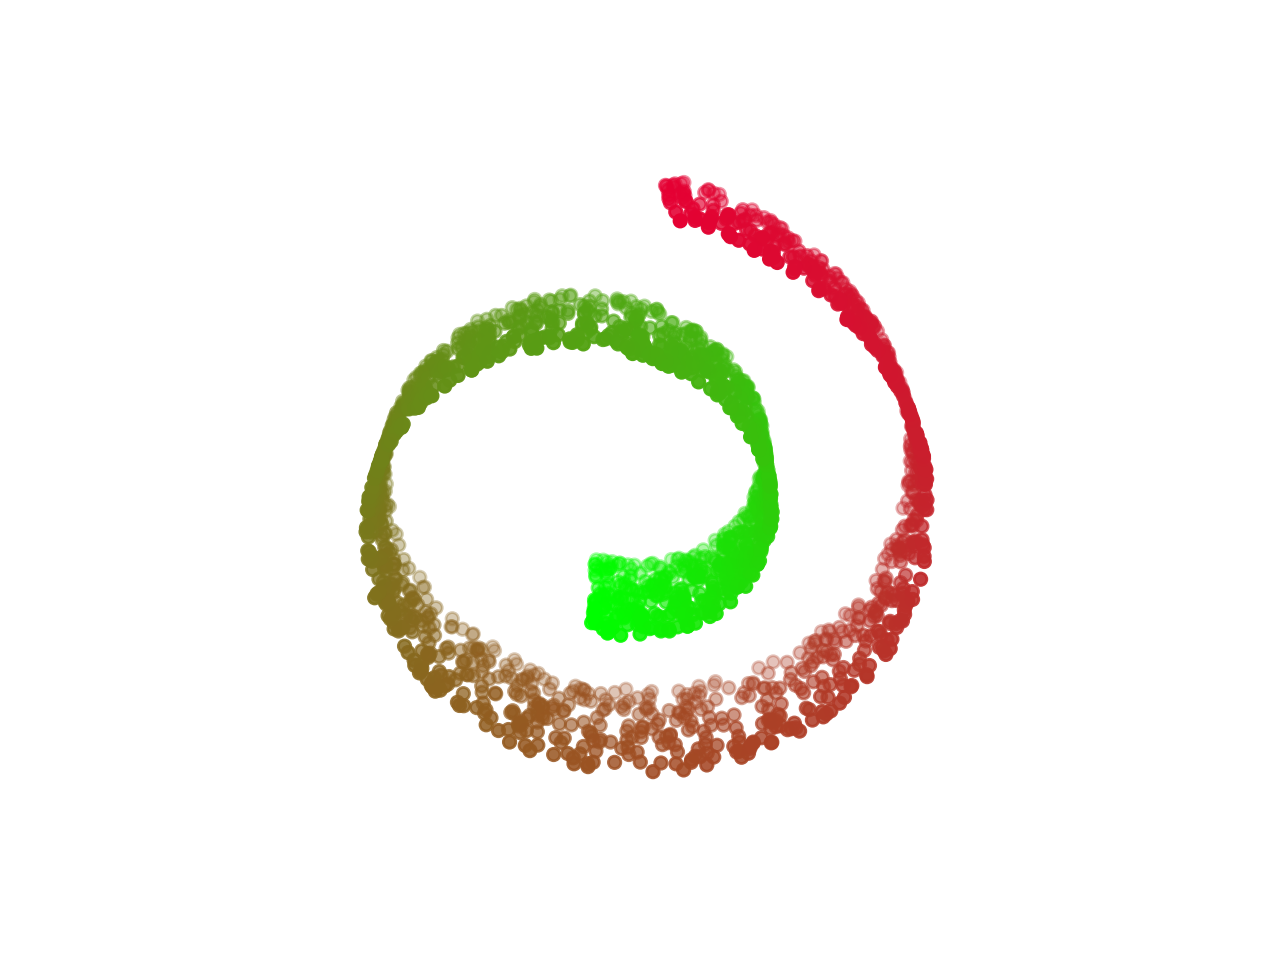

In [11]:
%matplotlib notebook
# generate datapoints along a nonlinear manifold (Same generation, please copy and paste)
m = 2000
t = 3*np.pi/2*np.random.uniform(1,3,m)
x = t*np.cos(t)
y = t*np.sin(t)
z = 21*np.random.uniform(0,1,m)
# visualize the datapoints
pix = (t-np.min(t))/(np.max(t)-np.min(t)) 
color = np.column_stack( (0.9*pix, 1-pix, 0.2*pix ) )
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z,c=color)
plt.axis('off')
plt.grid(b=None)
ax.view_init(99,-80)
plt.show()

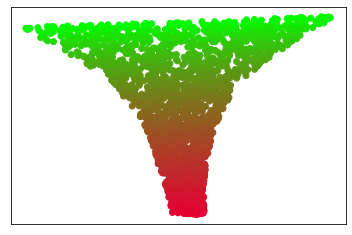

In [12]:
%matplotlib inline
# perform LLE for the given dataset and plot the output
X = np.row_stack( (x, y, z) )
n = 10                          # number of nearest neighbors
k = 2                                     # reduced dimension
Z = lle(X,n,k)
plt.scatter(Z[0,:],Z[1,:],c=color)
plt.xticks([])
plt.yticks([])
plt.show()

### Example 2: 3-D data in xyz axes

<IPython.core.display.Javascript object>


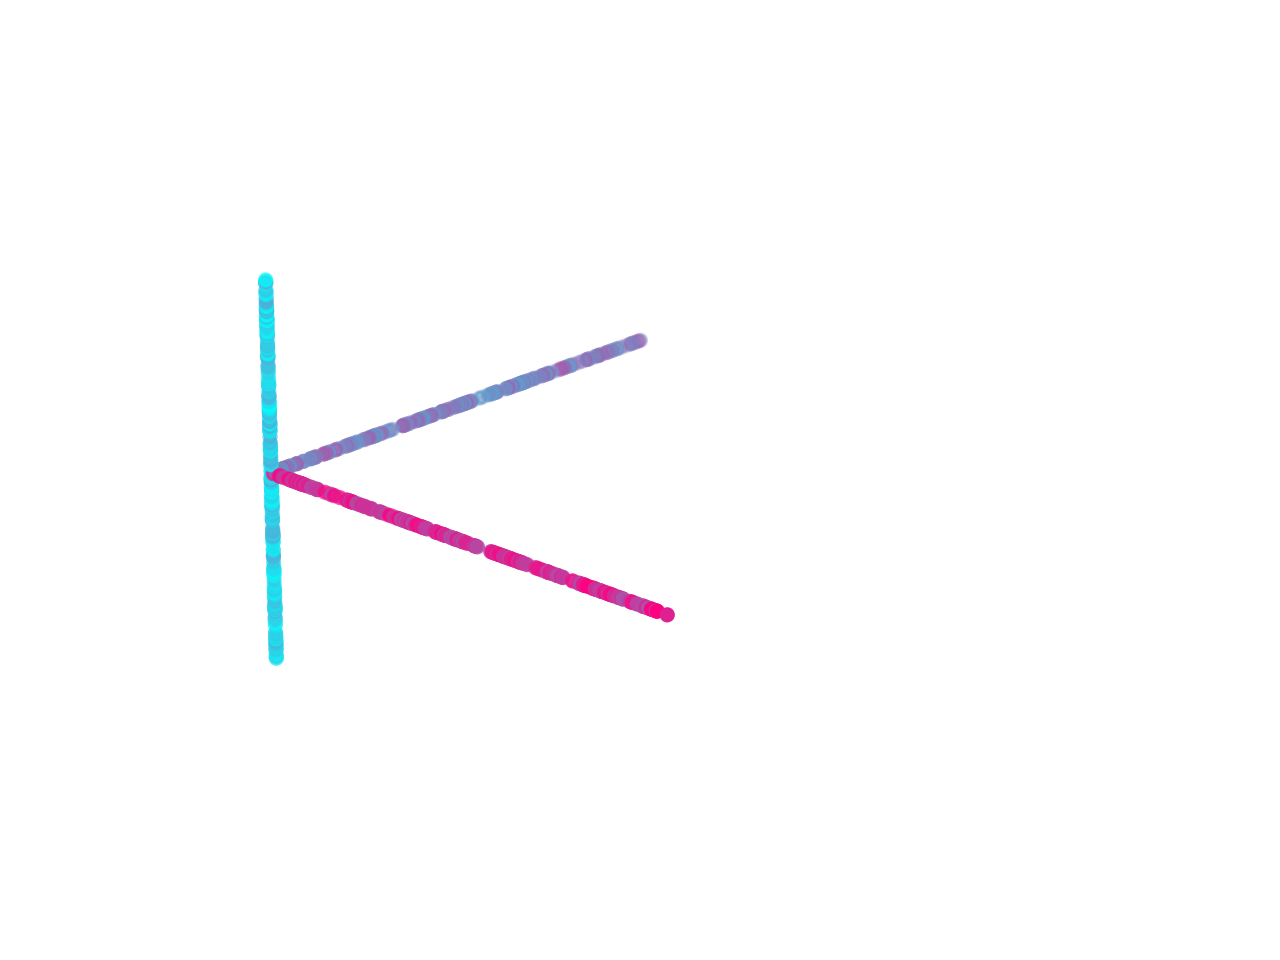

In [13]:
%matplotlib notebook
# generate the datapoints in xyz axes
m = 600            # choose m as a multiple of 3
x = np.row_stack( (np.random.uniform(0,1,int(m/3)),np.zeros(int(m/3)),np.zeros(int(m/3))) )
y = np.row_stack( (np.zeros(int(m/3)),np.random.uniform(0,1,int(m/3)),np.zeros(int(m/3))) )
z = np.row_stack( (np.zeros(int(m/3)),np.zeros(int(m/3)),np.random.uniform(-1,1,int(m/3))) )
# visualize the datapoints
pix = np.linspace(0,1,m)
color = np.column_stack((1-pix,pix,(1+pix)/2))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z,c=color)
plt.axis('off')
plt.grid(b=None)
ax.view_init(21,-47)
plt.show()

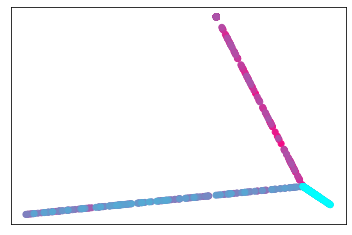

In [14]:
%matplotlib inline
# perform LLE for the given dataset and plot the output
X = np.column_stack((x,y,z))
n = 10                  # number of nearest neighbors
k = 2                             # reduced dimension
Z = lle(X,n,k)
plt.scatter(Z[0,:],Z[1,:],c=color)
plt.xticks([])
plt.yticks([])
plt.show()